### Clustering with algoritm Gaussian kernel fuzzy c-means 

This is a implementation with dataset Multiple features in the repository (https://archive.ics.uci.edu/dataset/72/multiple+features)
we apply with tree datasets (mfeat-fac, mfeat-fou, mfeat-kar) for each do it:
  - 50 times, with c=10 for partation fuzzy
  - compute Modified partition coefficient
  - paraments $T = 100, \epsilon=10^{-6}, m = {1.01, 1.1, 1.6}$

  - show the bests with based in fuction cost:
    - prototatipes ${g_{1},..., g_n}$
    - widths ${s_1,..., s_n}$
    - confusion matrix 


base article: Gaussian Kernel Fuzzy C-Means with Width Parameter Computation and Regularization.
PATTERN RECOGNITION, v. 143, p. 109749, 2023, 
doi: https://doi.org/10.1016/j.patcog.2023.109749 

***
Gaussian kernel function
***
$$
  K^{(s_i)}(x_l, x_k) = exp{
    \displaystyle 
    \Bigg \{
      -\frac{1}{2}
      \sum \limits _{j=1}^p 
        \frac{1}{{s^2}_{ij}}
        (x_{lj} - x_{kj})^2
    \Bigg \} 
    }
$$

***
objective  function
***

$$
  J_{KFCM-K-W.2} = 
    \displaystyle 
      \sum \limits _{i=1}^c 
        \sum \limits _{k=1}^n 
          (u_{ki})^m
          (2 - 2{K^{(s_i)}(x_k, g_i)})
$$

$
  s.t. u_{ki} \ge 0
$ and 
$
  \sum \limits _{i=1}^c 
    u_{ki} = 1
$

***
width
***

$$
\frac{1}{s_{ij}} = 
  \frac{
    \Bigg \{
      \prod \limits _{h=1}^p 
        \sum \limits _{k=1}^n 
          {(u_{ki})^m}
          {K^{(s_i)}(x_k, g_i)}
          {(x_{kh} - g_{ih})^2}
    \Bigg \}^
    {
      \frac{1}{p}
    }
  }{
    \sum \limits _{k=1}^n 
      {(u_{ki})^m}
      {K^{(s_i)}(x_k, g_i)}
      {(x_{kj} - g_{ij})^2}
  }
$$
$$
  \forall (1 \le i \le c),
    \prod \limits _{h=1}^p 
      \frac{1}{s_{ij}}
    = 1
$$

***
prototipes
***

$$
g_i = 
  \frac{
    \sum \limits _{k=1}^n 
      {(u_{ki})^m}
      {K^{(s_i)}(x_k, g_i)}
      {x_k}

  }{
    \sum \limits _{k=1}^n 
      {(u_{ki})^m}
      {K^{(s_i)}(x_k, g_i)}
  } 
$$
$$
  \forall (1 \le i \le c)
$$

***
fuzzy matrix
***

$$
  u_{ki} = 
    \Bigg [ 
      \sum \limits _{h=1}^c 
        \Bigg ( 
          \frac{
            2 - 2{K^{(s_i)}(x_k, g_i)}
          }{
            2 - 2{K^{(s_i)}(x_k, g_h)}
          }
        \Bigg )^
        {
          \frac{1}{m-1}
        } 
    \Bigg ] ^{-1}
$$

### Librarys

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


### Data transform

In [2]:
class Cleaner(BaseEstimator, TransformerMixin):
  def __init__(self):
    super()
  
  def read_dataset(self, filename):
    X = pd.read_csv(filename, header=None, delim_whitespace=True)
    y = pd.DataFrame({X.shape[1]: np.arange(0, X.shape[0])//200})
    return X, y
  def fit(self, X, y):
    return self
  
  def transform(self, X: pd.DataFrame, y=pd.DataFrame):
    y_lenth = len(y)
    if y_lenth:
      # key = "class"
      # y = pd.DataFrame({key: y})
      values = pd.concat([X, y], axis=1)
    else:
      values = X.copy()

    values = values.dropna()
    values = values.drop_duplicates()
    if y_lenth:
      return values[X.columns.values], values[values.columns.values[-1]]
    return values
  
  def fit_transform(self, X, y=pd.DataFrame):
      return self.fit(X, y).transform(X, y)
  
class Transformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    super()
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    if type(X) == np.ndarray:
      return X
    return X.values
  def fit_transform(self, X, y=None):
    return self.fit(X, y).transform(X, y)

### Metrics

In [3]:
class Gaussian:
  def distance(self, g, x, sigma):
    if x.shape[0] == 0 or sigma.shape[0] == 0:
      raise Exception
    distance = (x - g)**2
    distance_sigma = distance / sigma
    summatory_distance = (-1/2)*np.sum(distance_sigma, 1)
    return np.exp(summatory_distance)

class Metrics:
  def mpc(u: np.array):
    # modified partition coefficient
    n, k = u.shape
    f = np.trace(u.dot(u.T)) / n

    mpc = 1 - (k/(k - 1))*(1 - f)
    return mpc
  def ars(y_true, y_pred):
    # adjusted rand score
    return adjusted_rand_score(y_true, y_pred)

### Model

In [4]:
# tá funcionando bonitinho
class Shower():
  def show_grafico(self, x):
    _, axes = plt.subplots()
    markers = ['^','x','+']
    p = self.predict(self.G, x)
    
    for (c, (x_1, x_2)) in zip(p, x):
      r, g, b, a = .9*((c+1)/self.num_class), .9*((c*1.1)/self.num_class), .9*((c*1.2)/self.num_class), 0.1
      
      axes.plot(x_1, x_2, "ro", marker=markers[c])
        
    raio = self.distance_classes() / 2
    
    for i, (x_1, x_2) in enumerate(self.G):
        
        plt.plot(x_1, x_2, "go", scalex=0.01,scaley=0.01)
        r, g, b, a = .9*((i+1)/self.num_class), .9*((i*1.1)/self.num_class), .9*((i*1.2)/self.num_class), 0.9
        c = plt.Circle((x_1, x_2), raio, color=(r, g, b, a), fill=False)

        axes.set_aspect(aspect = 1, adjustable = "datalim", anchor="SW")
        axes.add_artist(c)
    plt.show()

  def show_function_objetive(self, data_f, params):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

    # plot box plot
    axs[0].boxplot(data_f)
    # axs[0].set_title('funcão objetivo e m ')
    axs[0].yaxis.grid(True)
    axs[0].set_xticks([y + 1 for y in range(len(data_f))],
                  labels=params)
    axs[0].set_xlabel('m')
    axs[0].set_ylabel("f")

    plt.show()

  def show_labels(self, x, filename):
    # Data
    k, n = x.shape
    plt.figure(figsize=(20, 6))
      
    # Labels  
    xlabs = np.arange(k)
    ylabs = np.arange(n)
            
    # Heat map
    _, ax = plt.subplots(constrained_layout=True)
    
    # ax.figure()
    ax.set_axis_off() #= [0.1, 0.1, 0.8, 0.8] #.add_axes()
    ax.imshow(x)
    if n < 10:
      # Add the labels
      ax.set_xticks(ylabs)
      ax.set_yticks(xlabs)

      # Add the values to each cell
      for i in range(len(xlabs)):
          for j in range(len(ylabs)):
              _ = ax.text(j, i , round(x[i, j], 1),
                            ha = "center", va = "center", color = (0,0,0)) # "w"
    if filename:
      plt.savefig(filename, dpi=150)
    plt.show()
  
  def show_G_S(self, folder):
    # show the values of Gs and S(widths)
    if not os.path.isdir(folder):
      os.makedirs(folder) 
    print("Gs")
    self.show_labels(self.G, f"{folder}/G")
    print("S2s")
    self.show_labels(self.sigma, f"{folder}/sigma")

class Model():
  def __init__(self, loss = Gaussian(), var_type=np.double) -> None:
    # model base
    self.loss = loss
    self.var_type = var_type
    
  def predict(self, X, is_preprocessing=False, argmax=True):
    # here we make predict in x
    n = X.shape[0] 
    k = self.G.shape[0]

    if is_preprocessing:
      X = self.preprocesssing(X)
    u = np.zeros((n, k), self.var_type)

    distances = np.array([2 - 2*self.loss.distance(self.G[i], X, self.sigma[i]) for i in range(k)]).T

    expoente = 1/(self.m - 1)

    for i in range(n):
      
      ds = distances[i]==0
      if (ds).any():
        summation_c_i_1 = np.zeros((k))
        summation_c_i_1[ds] = 1
      else:
        summation_c = np.array([((distances[i]/distances[i, h])**expoente) for h in range(k)])#.T 
        
        summation_c_i = np.sum(summation_c, 0)
        summation_c_i_1 = np.power(summation_c_i, -1)
        
      u[i] = summation_c_i_1.copy()
    if argmax:
      return u.argmax(1)
    return u
    # if argmax:
    

  def set_g(self, g):
    self.G = g.copy()

  def set_sigma(self, sigma):
    self.sigma = sigma.copy()

  def preprocesssing(self, X):
    pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),])    
    
    return pipeline.transform(X)
  
  def save_model(self, filename):
    # Save the model in json file
    json_object = json.dumps({
      "G": self.G.tolist(),
      "sigma": self.sigma.tolist(),
      "m": self.m
    }, indent=2) #  
    # Writing to sample.json
    folder = "/".join(filename.split("/")[:-1])
    if not os.path.isdir(folder):
      os.makedirs(folder) 

    with open(filename, "w") as outfile:
        outfile.write(json_object)
  
  def load_model(self, filename):
    # Reading from json file
    with open(filename, 'r') as openfile:
      json_object = json.load(openfile)
      self.G = np.array(json_object["G"])
      self.sigma = np.array(json_object["sigma"])
      self.m = json_object["m"]

class FuzzyCMeansGaussianS2(Shower, Model):
  def __init__(self, num_class, epochs, threshold, loss=Gaussian(),  m = 1.1, seeder=None, verbose = False) -> None:
    # load the hiperparams
    super().__init__(loss=loss, var_type = np.double)
    self.num_class = num_class
    self.m = m 
    self.verbose = verbose
    self._only = True
    if seeder:
      self.seeder = seeder
      np.random.seed(seeder)
      
    self.threshold = threshold
    self.epochs = epochs 
 
  def init_g(self, x):
    # here we get random prototipes to train
    args = np.random.choice(x.shape[0], self.num_class, replace=False)
    self.G = x[args].copy()

  def init_u(self, x):
    # we calcule initial matrix of membership
    g = self.G.copy()
    sigma = self.sigma.copy()
    self.n = x.shape[0]
    self.k = g.shape[0]
    
    self.U = np.zeros((self.n, self.k), self.var_type)

    distances = np.array([2 - 2*self.loss.distance(g[i], x, sigma[i]) for i in range(self.k)]).T

    expoente = 1/(self.m-1)

    for i in range(self.n):
      # summation_c = np.array([(distances[i, h] / distances[i])**expoente for h in range(self.k)]) 
      # np.divide
      # summation_c = np.array([(distances[i] / distances[i, h])**expoente for h in range(self.k)]) #.T 
      ds = distances[i]==0
      if (ds).any():
        summation_c_i_1 = np.zeros((self.k))
        summation_c_i_1[ds] = 1
        self.U[i] = summation_c_i_1.copy()

      else:
        summation_c = np.array([((distances[i]/distances[i, h])**expoente) for h in range(self.k)])#.T 
        
        summation_c_i = np.sum(summation_c, 0)
        summation_c_i_1 = np.power(summation_c_i, -1)
        
        membership_is_nan = np.isnan(summation_c_i_1)
        
        summation_u = np.sum(summation_c_i_1, where=membership_is_nan==False)

        summation_u_1 = 1 - summation_u
        abs_summation_u_1 = np.abs(summation_u_1)
        
        if abs_summation_u_1 > .01:
          arg = summation_c_i_1.argmax()
          summation_c_i_1[arg] = summation_c_i_1[arg] + summation_u_1
          
          self.U[i] = summation_c_i_1.copy()
        else:
          self.U[i] = summation_c_i_1.copy() 
   
  def init_sigma(self, x):
    # we calcule initial matrix of widths each 1
    self.p = x.shape[1]
    self.k = self.G.shape[0]
    self.sigma = np.ones((self.k, self.p), dtype=self.var_type)

  # passo 1
  def otm_prototivo(self, g, u, x, sigma):
    new_g = g.copy()
    u_i = u**self.m

    for i in range(self.k):
      n_g = self.loss.distance(g[i], x, sigma[i])
      
      u_m_g = (u_i[:,i]*n_g)#*
      u_m_gx = ((x.T)*u_m_g).T

      s_umg = np.sum(u_m_g)
      s_umgx = np.sum(u_m_gx, 0)
      
      new_g[i] = s_umgx / s_umg 
    return new_g
  
  # passo 2
  def otm_u(self, g, x, sigma):
    new_u = np.zeros((self.n, self.k), dtype=self.var_type)  
    
    distances = np.array([2 - 2*self.loss.distance(g[i], x, sigma[i]) for i in range(self.k)]).T
    
    expoente = 1/(self.m-1)
    for i in range(self.n):
      
      ds = distances[i]==0
      if (ds).any():
        summation_c_i_1 = np.zeros((self.k))
        summation_c_i_1[ds] = 1
        new_u[i] = summation_c_i_1.copy()
        
      else:
        summation_c = np.array([((distances[i]/distances[i, h])**expoente) for h in range(self.k)])#.T 
        
        summation_c_i = np.sum(summation_c, 0)

        summation_c_i_1 = np.power(summation_c_i, -1)
        
        membership_is_nan = np.isnan(summation_c_i_1)
        
        summation_u = np.sum(summation_c_i_1, where=membership_is_nan==False)

        summation_u_1 = 1 - summation_u
        abs_summation_u_1 = np.abs(summation_u_1)
        # if 
      
        if summation_u == 0 or membership_is_nan.any():
          count = np.sum(membership_is_nan) # total nan
          new_u[i] = np.nan_to_num(summation_c_i_1, nan = summation_u_1/count)     
        elif abs_summation_u_1 > .01:
          arg = summation_c_i_1.argmax()
          summation_c_i_1[arg] = summation_c_i_1[arg] + summation_u_1
          
          new_u[i] = summation_c_i_1.copy()
        else:
          new_u[i] = summation_c_i_1.copy()
    return new_u

  def otm_sigma(self, x, g, u):
    s = self.sigma.copy()
    
    ui = (u**(self.m))
    
    for i in range(self.k):
      g_i = g[i]
      ui_per = ui[:,i]
      

      g_d = self.loss.distance(g_i, x, s[i]) 
      e_d = (x - g_i)**2 
      
      s_cn = e_d.T*(ui_per*g_d)
      
      if s_cn.shape[1] != 1:
        ss_cn = np.sum(s_cn, 1).copy()
      else:
        ss_cn = np.squeeze(s_cn, 1).copy()
        

      s_p = np.prod(ss_cn)
      s_p = s_p**(1/self.p)
      
      s_ij = s_p / ss_cn 

      r_r = s_ij[np.isnan(s_ij) == False]
      p_r = np.prod(r_r)
      
      s_r = np.abs(1 - p_r)
      
              
      # verificacao do produtorio para a classe que deve ser 1
      if p_r == 0: 
        # quando os Si forem muito pequeno o produtorio dá zero por causa computacional
        # sendo assim eu redistubuo a partir do inverso da media
        # ss_cn => todos denominadores de Si
        # [1/2, 1/2, 1/2] = [0.1/0.2 0.1/0.2 0.1/0.2] 

        # [S_i1, S_i2, S_i3] = [0.000398*0.0000038*0.000067/0.000398 
        #                       0.000398*0.0000038*0.000067/0.0000038 
        #                       0.000398*0.0000038*0.000067/0.000067]
        #  [S_i1, S_i2, S_i3] = [2.5460e-10, 2.6666e-08, 1.5124e-09]

        # -1 aqui faco a media dos denominadores dos si 
        # que no caso o resultado dos somatorios 
        teste = False

        if teste:
          m_s = np.sum(ss_cn)/(self.p) 
        # m_s = sum([0.2 0.2 0.2])/2

        # p
        # m_s = sum([0.000398 0.0000038 0.000067])/3
        # m_s = 0.00015626666666666668
        # p - 1
        # m_s = sum([0.000398 0.0000038 0.000067])/2
        # m_s = 0.0002344



        # ss_cn = ss_cn*(1/m_s)
        if teste:
          im_s = 1/(m_s)
          new_ss_cn = ss_cn*im_s
        else:
          new_ss_cn = (1 - ss_cn) #**(1/(self.p))
        # new_ss_cn = [0.0033 0.0033 0.0033]/0.2


        # p
        # new_ss_cn = [0.000398 0.0000038 0.000067]/0.00015626666666666668
        # new_ss_cn = [2.54692833 0.02431741 0.42875427]

        # p - 1
        # new_ss_cn = [0.000398 0.0000038 0.000067]/0.0002344
        # new_ss_cn = [1.69795222 0.0162116 0.28583618]

        new_s_p = np.prod(new_ss_cn)
        # p
        # prod(new_ss_cn) = 0.0265547628046677

        # p -1
        # prod(new_ss_cn) = 0.00786807786804969


        new_s_p = new_s_p**(1/self.p)
        # p
        # new_s_p = 0.29834182508986407

        # p -1
        # new_s_p = 0.08870218637694163

        
        new_r = new_s_p / new_ss_cn 

        # p
        # new_r = 0.0265547628046677/[2.54692833 0.02431741 0.42875427]
        # new_r = [0.1171379 , 12.2686533 ,  0.69583407]
        # prod(new_ss_cn) = 0.75

        # p -1
        # new_r = 0.4898979485566356/[1.69795222 0.0162116 0.28583618]
        # new_r = [0.05224068, 5.47152434, 0.31032526 ]

        prod = np.prod(new_r)
        # p
        # prod = 1
        # p -1
        # prod = 0.0887021863769416

        if np.isnan(prod)==False:
          s[i] = new_r.copy()
        
      elif s_r > .1:
        # para quando o produtorio de Ss dá diferente de 1 
        if r_r.shape[0] == s_ij.shape[0]:
          s[i] = s_ij/(p_r**(1/s_ij.shape[0]))
        else:
          s_prod = (1/(p_r**(1/s_ij.shape[0])))
          s[i] = np.nan_to_num(s_ij, copy=True, nan=s_prod)
      else:
        s[i] = s_ij.copy()
          
    return s

  def funcao_objetivo(self, x, g, u, sigma):
    # k = g.shape[0]
    u_i = u**self.m
    f = np.zeros(self.k, dtype=self.var_type)
    
    s_d = np.zeros(x.shape[0], dtype=self.var_type)
    w = np.zeros(x.shape[0], dtype=self.var_type)
    for i in range(self.k):
      s_d = 2 - 2*self.loss.distance(g[i], x, sigma[i])
      
      w = s_d.T*(u_i[:, i])
      f[i] = np.sum(w)
      
    return np.sum(f)

  def atualiza_GUS2(self, g, u, sigma):
    self.G = g
    self.U = u
    self.sigma = sigma

  def fit(self, x, y, verbose = False):
    self.redu = True
    
    self.init_g(x)
    self.init_sigma(x)
    self.init_u(x)

    j = self.funcao_objetivo(x, self.G, self.U, self.sigma) 
    if self._only:
      print("epoca:", 0, "funcão objetivo:", j) #, new_f

    
    for epoch in range(self.epochs):
      # "passo 1"
      new_sigma = self.otm_sigma(x, self.G, self.U)

      # "passo 2"
      new_g = self.otm_prototivo(self.G, self.U, x, new_sigma)

      # "passo 3"
      new_u = self.otm_u(new_g, x, new_sigma)

      new_j = self.funcao_objetivo(x, new_g, new_u, new_sigma)
      if self._only:
        print(f"epoca: {epoch + 1} funcão objetivo: {new_j}")# f,
        print(f"Modified partition coefficient  {Metrics.mpc(self.U)},  {Metrics.ars(y, self.U.argmax(1))}")# f,
      
      # silhouette_score
      if verbose:
        self.show_grafico(x)
      
      
      dif = np.abs(new_j - j)
      # new_j > j
      if (np.isnan(new_j)==True or dif < self.threshold):
        return
      else:
        j = new_j
        self.atualiza_GUS2(new_g, new_u, new_sigma)

class Trainer(FuzzyCMeansGaussianS2):
  def __init__(self, 
                num_class, 
                epochs, 
                threshold,
                model_creator, 
                filename, 
                loss = Gaussian(), 
                m = 1.1, 
                verbose = False, 
                repeat = 1) -> None:
    # load the hiperparams
    super().__init__(num_class, epochs, threshold, loss=loss, m = m)
    self.num_class = num_class
    self.var_type = np.double
    # self.var_type = np.float
    self.verbose = verbose      
    self.threshold = threshold
    self.epochs = epochs 
    self.repeat = repeat
    self.model_creator = model_creator
    self.filename = filename
    self.metrics = {
      "objetive_function": [],
      "mpc": [],
      "ars": [],
    }
    
  def fit(self, X, y):
    j = np.inf
    
    for i in range(self.repeat):
      model = self.model_creator(num_class=self.num_class, epochs=self.epochs, threshold=self.threshold, loss=self.loss, m=self.m, verbose=self.verbose)
      model._only = False
      model.fit(X, y)
      new_j = model.funcao_objetivo(X, model.G, model.U, model.sigma)
      new_mpc = Metrics.mpc(model.U)
      new_ars = Metrics.ars(y, model.U.argmax(1))


      print(f"repeation: {i + 1} funcão objetivo: {new_j}")
      print(f"Modified partition coefficient: {new_mpc},  adjusted rand score: {new_ars}")

      self.metrics["objetive_function"].append(new_j)
      self.metrics["mpc"].append(new_mpc)
      self.metrics["ars"].append(new_ars)

      if new_j < j:
        self.G = model.G
        self.U = model.U
        self.sigma = model.sigma
        j = new_j
    
    
    self.save_model(f"./model/{self.m}/{self.filename}")
    self.save(f"./metrics/{self.m}/{self.filename}")

  def save(self, filename):
    if not len(self.metrics["objetive_function"]):
      print("the models is not fit")
      return
    # Save the model in json file
    json_object = json.dumps(self.metrics, indent=2) #  
    # Writing to sample.json
    folder = "/".join(filename.split("/")[:-1])
    if not os.path.isdir(folder):
      os.makedirs(folder) 

    with open(filename, "w") as outfile:
        outfile.write(json_object)
  


## fit the model with datasets

In [9]:
metrics = {1.1: {}, 1.6: {}}

### m = 1.1

#### set m expoent fuzzy

In [6]:
m = 1.1

#### datasets -> mfeat-fac

In [14]:
cleaner = Cleaner()
X, y = cleaner.read_dataset("datasets\mfeat-fac")
X_clean, y_clean = cleaner.transform(X, y)

model = Trainer(num_class = 10, 
                epochs = 100, 
                threshold = 1e-6, 
                model_creator=FuzzyCMeansGaussianS2, 
                m = m, 
                verbose = False, 
                repeat = 50,
                filename="mfeat-fac/model.json")

pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X_clean, y_clean)

metrics[m]["mfeat-fac"] = model.metrics


repeation: 1 funcão objetivo: 12.695396592612276
Modified partition coefficient: 0.9196245699004217,  adjusted rand score: 0.49073624784389197
repeation: 2 funcão objetivo: 12.8404760851869
Modified partition coefficient: 0.9100984825398918,  adjusted rand score: 0.44396670712852265
repeation: 3 funcão objetivo: 12.679782558771912
Modified partition coefficient: 0.9155504728844238,  adjusted rand score: 0.43550359142651274
repeation: 4 funcão objetivo: 12.63551420604752
Modified partition coefficient: 0.9175824126728777,  adjusted rand score: 0.48846289250691377
repeation: 5 funcão objetivo: 12.714638791208772
Modified partition coefficient: 0.908580475785259,  adjusted rand score: 0.4356830598381332
repeation: 6 funcão objetivo: 12.695395261733871
Modified partition coefficient: 0.9196428949899331,  adjusted rand score: 0.49070122237756447
repeation: 7 funcão objetivo: 12.691577813701443
Modified partition coefficient: 0.9203581551637047,  adjusted rand score: 0.508337175932385
repeat

Gs


<Figure size 1440x432 with 0 Axes>

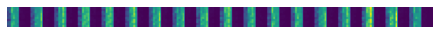

S2s


<Figure size 1440x432 with 0 Axes>

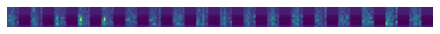

In [15]:
model.show_G_S(f"./figs/{m}/mfeat-fac")

Modified partition coefficient:  {0: 0.9728910855056683, 1: 0.8569937701456476, 2: 0.9013082179076886, 3: 0.9163677324486326, 4: 0.9224263633115105, 5: 0.8958323540228667, 6: 0.9293828140786752, 7: 0.9083706753454242, 8: 0.9278985446084246, 9: 0.9313654505658271}
Índice de Rand corrigido: 0.5079241260917384


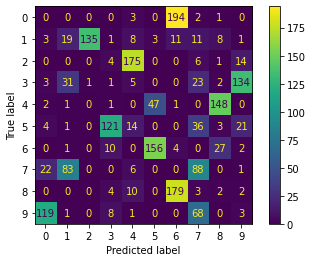

In [24]:
pertencify = pipeline.predict(X, is_preprocessing=True, argmax=False)
y_predict = pertencify.argmax(1)

mpcs = {i: Metrics.mpc(pertencify[y.values[:,0]==i]) for i in range(model.num_class)}

print(f"Modified partition coefficient:  {mpcs}")# f,
print(f"Índice de Rand corrigido: {Metrics.ars(y.values[:,0], y_predict)}")

cm = confusion_matrix(y.values[:,0], y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

#### datasets -> mfeat-fou

In [25]:
cleaner = Cleaner()
X, y = cleaner.read_dataset("datasets\mfeat-fou")
X_clean, y_clean = cleaner.transform(X, y)

model = Trainer(num_class = 10, 
                epochs = 100, 
                threshold = 1e-6, 
                model_creator=FuzzyCMeansGaussianS2, 
                m = m, 
                verbose = False, 
                repeat = 50,
                filename="mfeat-fou/model.json")

pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X_clean, y_clean)

metrics[m]["mfeat-fou"] = model.metrics

repeation: 1 funcão objetivo: 333.23987136433743
Modified partition coefficient: 0.8556777372536637,  adjusted rand score: 0.4517313224403207
repeation: 2 funcão objetivo: 373.1657875078203
Modified partition coefficient: 0.79720650138533,  adjusted rand score: 0.3430323628756038
repeation: 3 funcão objetivo: 334.74083338699177
Modified partition coefficient: 0.8734630204657172,  adjusted rand score: 0.4149872169345159
repeation: 4 funcão objetivo: 354.3056706117417
Modified partition coefficient: 0.8603932010285629,  adjusted rand score: 0.38630442629254363
repeation: 5 funcão objetivo: 333.26493383412935
Modified partition coefficient: 0.8538480528343041,  adjusted rand score: 0.4587246452322728
repeation: 6 funcão objetivo: 343.0274510232078
Modified partition coefficient: 0.8536912950120141,  adjusted rand score: 0.41418781717742353
repeation: 7 funcão objetivo: 332.7034806074569
Modified partition coefficient: 0.8431880876163171,  adjusted rand score: 0.4581021198063122
repeation:

Gs


<Figure size 1440x432 with 0 Axes>

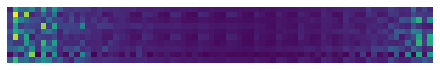

S2s


<Figure size 1440x432 with 0 Axes>

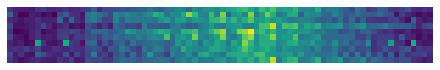

In [26]:
model.show_G_S(f"./figs/{m}/mfeat-fou")

Modified partition coefficient:  {0: 0.9911928430239498, 1: 0.6853637064625202, 2: 0.9231986614440137, 3: 0.8356306120332061, 4: 0.8277168130813162, 5: 0.778174275471682, 6: 0.9039019832717048, 7: 0.8907245366757349, 8: 0.8468562388043606, 9: 0.8843555378414631}
Índice de Rand corrigido: 0.4602711858877749


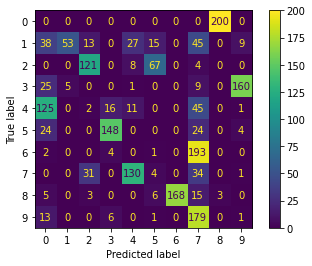

In [27]:
pertencify = pipeline.predict(X, is_preprocessing=True, argmax=False)
y_predict = pertencify.argmax(1)

mpcs = {i: Metrics.mpc(pertencify[y.values[:,0]==i]) for i in range(model.num_class)}

# model.init_u
print(f"Modified partition coefficient:  {mpcs}")# f,
print(f"Índice de Rand corrigido: {Metrics.ars(y.values[:,0], y_predict)}")# f,

cm = confusion_matrix(y.values[:,0], y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

#### datasets -> mfeat-zer

In [10]:
cleaner = Cleaner()
X, y = cleaner.read_dataset("datasets\mfeat-zer")
X_clean, y_clean = cleaner.transform(X, y)
X, y = Cleaner().transform(X, y)

model = Trainer(num_class = 10, 
                epochs = 100, 
                threshold = 1e-6, 
                model_creator=FuzzyCMeansGaussianS2, 
                m = m, 
                verbose = False, 
                repeat = 50,
                filename="mfeat-zer/model.json")

pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X_clean, y_clean)

metrics[m]["mfeat-zer"] = model.metrics



repeation: 1 funcão objetivo: 1687.3432599081925
Modified partition coefficient: 0.7308318498382255,  adjusted rand score: 0.3283838290659938
repeation: 2 funcão objetivo: 1689.2272834441906
Modified partition coefficient: 0.7345981246918798,  adjusted rand score: 0.3040765686931116
repeation: 3 funcão objetivo: 1694.7743128984605
Modified partition coefficient: 0.7327397203613301,  adjusted rand score: 0.30304223964151483
repeation: 4 funcão objetivo: 1686.519279373414
Modified partition coefficient: 0.7305148882186374,  adjusted rand score: 0.32947699187357377
repeation: 5 funcão objetivo: 1686.5730951373646
Modified partition coefficient: 0.7306084598720212,  adjusted rand score: 0.32942135337584466
repeation: 6 funcão objetivo: 1686.171012142426
Modified partition coefficient: 0.7305776028958852,  adjusted rand score: 0.3281166196280817
repeation: 7 funcão objetivo: 1732.4240023035543
Modified partition coefficient: 0.7277193040257038,  adjusted rand score: 0.2982760812135543
repea

Gs


<Figure size 1440x432 with 0 Axes>

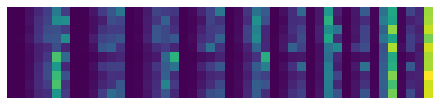

S2s


<Figure size 1440x432 with 0 Axes>

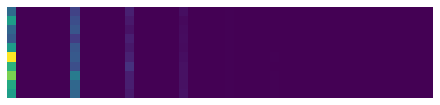

In [11]:
model.show_G_S(f"./figs/{m}/mfeat-zer")

Modified partition coefficient:  {0: 0.7871176211123321, 1: 0.8315022427005658, 2: 0.7455133779693637, 3: 0.7377432095444404, 4: 0.5749404915391423, 5: 0.6428513803461149, 6: 0.7207354885371251, 7: 0.8663432367121243, 8: 0.668076359867509, 9: 0.7311330015694928}
Índice de Rand corrigido: 0.3281166196280817


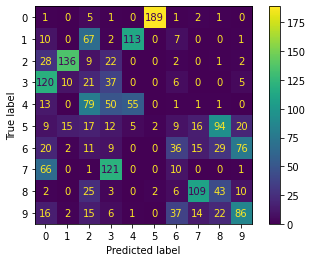

In [12]:
y_predict = pipeline.predict(X)

mpcs = {i: Metrics.mpc(model.U[y==i]) for i in range(model.num_class)}

print(f"Modified partition coefficient:  {mpcs}")# f,
print(f"Índice de Rand corrigido: {Metrics.ars(y, model.U.argmax(1))}")# f,

cm = confusion_matrix(y, y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

#### datasets -> iris

In [31]:
iris = datasets.load_iris()
X = pd.DataFrame(iris.data)
y = pd.DataFrame({len(X.columns.values):iris.target})
cleaner = Cleaner()

In [32]:
X_clean, y_clean = cleaner.transform(X, y)

model = Trainer(num_class = 3, 
                epochs = 100, 
                threshold = 1e-6, 
                model_creator=FuzzyCMeansGaussianS2, 
                m = m, 
                verbose = False, 
                repeat = 50,
                filename="iris/model.json")

pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X_clean, y_clean)

metrics[m]["iris"]= model.metrics


repeation: 1 funcão objetivo: 0.40577975395063653
Modified partition coefficient: 0.9869917414360757,  adjusted rand score: 0.9035691663683182
repeation: 2 funcão objetivo: 0.4057794770865068
Modified partition coefficient: 0.9869916884562886,  adjusted rand score: 0.9035691663683182
repeation: 3 funcão objetivo: 0.405779255018322
Modified partition coefficient: 0.9869916412035631,  adjusted rand score: 0.9035691663683182
repeation: 4 funcão objetivo: 0.4057803222672156
Modified partition coefficient: 0.9869918543527524,  adjusted rand score: 0.9035691663683182
repeation: 5 funcão objetivo: 0.5360544839842194
Modified partition coefficient: 0.9901769658969805,  adjusted rand score: 0.443540461316264
repeation: 6 funcão objetivo: 0.4057804676663539
Modified partition coefficient: 0.9869918827589292,  adjusted rand score: 0.9035691663683182
repeation: 7 funcão objetivo: 0.40578074088031457
Modified partition coefficient: 0.986991936416916,  adjusted rand score: 0.9035691663683182
repeati

In [33]:
new_model = Model()
new_model.load_model(f"model/{m}/iris/model.json")
y_predict = new_model.predict(X, True)#.shape, X.shape


Gs


<Figure size 1440x432 with 0 Axes>

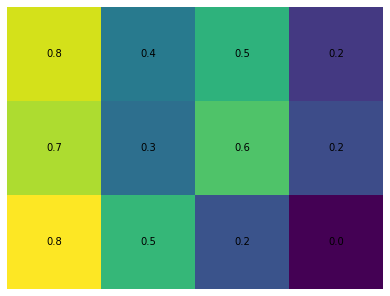

S2s


<Figure size 1440x432 with 0 Axes>

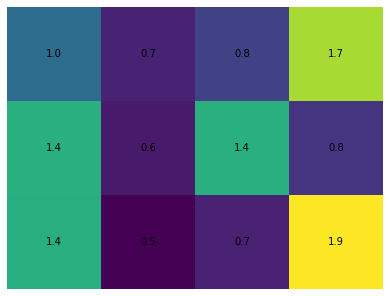

In [34]:
model.show_G_S(f"figs/{m}/iris")

Modified partition coefficient:  {0: 0.9999999952008485, 1: 0.9657793931508551, 2: 0.9954554984967504}
Índice de Rand corrigido: 0.9038742317748124


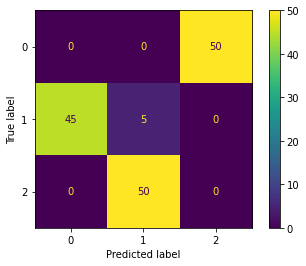

In [35]:
# y_predict = pipeline.predict(X) #(2000) <= (2000, 200)
# corrigir para os outros modelos
pertencify = pipeline.predict(X, is_preprocessing=True, argmax=False)
y_predict = pertencify.argmax(1)

mpcs = {i: Metrics.mpc(pertencify[y.values[:,0]==i]) for i in range(model.num_class)}

# model.init_u
print(f"Modified partition coefficient:  {mpcs}")# f,
print(f"Índice de Rand corrigido: {Metrics.ars(y.values[:,0], y_predict)}")# f,

cm = confusion_matrix(y, y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

### m = 1.6

#### set m expoent fuzzy

In [15]:
m = 1.6

#### datasets -> mfeat-fac

In [79]:
cleaner = Cleaner()
X, y = cleaner.read_dataset("datasets\mfeat-fac")
X_clean, y_clean = cleaner.transform(X, y)

model = Trainer(num_class = 10, 
                epochs = 100, 
                threshold = 1e-6, 
                model_creator=FuzzyCMeansGaussianS2, 
                m = m, 
                verbose = False, 
                repeat = 50, 
                filename=f"mfeat-fac/model.json",)

pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X_clean, y_clean)

metrics[m]["mfeat-fac"] = model.metrics


repeation: 1 funcão objetivo: 7.707799448734942
Modified partition coefficient: 0.2469169432448497,  adjusted rand score: 0.4369721799959069
repeation: 2 funcão objetivo: 7.746722481348928
Modified partition coefficient: 0.26694438223672934,  adjusted rand score: 0.4433318773535765
repeation: 3 funcão objetivo: 7.700742198764804
Modified partition coefficient: 0.25841230632196777,  adjusted rand score: 0.4588065642325849
repeation: 4 funcão objetivo: 7.700741308821522
Modified partition coefficient: 0.25838695605584583,  adjusted rand score: 0.459548379695934
repeation: 5 funcão objetivo: 7.707679163380071
Modified partition coefficient: 0.2473137267571054,  adjusted rand score: 0.44175732429207076
repeation: 6 funcão objetivo: 7.708380735745623
Modified partition coefficient: 0.24498464813236898,  adjusted rand score: 0.45517931070440976
repeation: 7 funcão objetivo: 7.707359753898185
Modified partition coefficient: 0.24797708220352443,  adjusted rand score: 0.47007338155099904
repeat

Gs


<Figure size 1440x432 with 0 Axes>

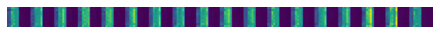

S2s


<Figure size 1440x432 with 0 Axes>

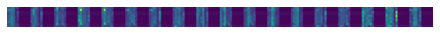

In [80]:
model.show_G_S(f"./figs/{m}/mfeat-fac")

Modified partition coefficient:  {0: 0.51708589157683, 1: 0.24199386761560793, 2: 0.1397994008347777, 3: 0.16635276556976297, 4: 0.24931612053238827, 5: 0.12704812495920892, 6: 0.35497961811155954, 7: 0.23158997471267673, 8: 0.32144927216057595, 9: 0.2342567904295504}
Índice de Rand corrigido: 0.45913002053329127


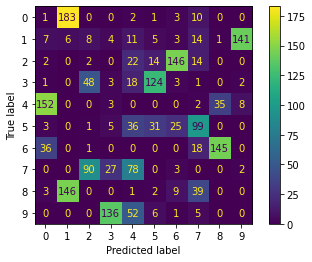

In [81]:
pertencify = pipeline.predict(X, is_preprocessing=True, argmax=False)
y_predict = pertencify.argmax(1)

mpcs = {i: Metrics.mpc(pertencify[y.values[:,0]==i]) for i in range(model.num_class)}

# model.init_u
print(f"Modified partition coefficient:  {mpcs}")# f,
print(f"Índice de Rand corrigido: {Metrics.ars(y.values[:,0], y_predict)}")# f,

cm = confusion_matrix(y.values[:,0], y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

#### datasets -> mfeat-fou

In [76]:
cleaner = Cleaner()
X, y = cleaner.read_dataset("datasets\mfeat-fou")
X_clean, y_clean = cleaner.transform(X, y)

model = Trainer(num_class = 10, 
                epochs = 100, 
                threshold = 1e-6, 
                model_creator=FuzzyCMeansGaussianS2, 
                m = m, 
                verbose = False, 
                repeat = 50,
                filename="mfeat-fou/model.json")

pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X_clean, y_clean)

metrics[m]["mfeat-fou"] = model.metrics

repeation: 1 funcão objetivo: 198.00809296109443
Modified partition coefficient: 0.12854919899044936,  adjusted rand score: 0.3888146951059072
repeation: 2 funcão objetivo: 197.97063519728547
Modified partition coefficient: 0.128680056243893,  adjusted rand score: 0.3874735950412212
repeation: 3 funcão objetivo: 205.46945900984346
Modified partition coefficient: 0.10805315633078316,  adjusted rand score: 0.27115689314229435
repeation: 4 funcão objetivo: 197.9710764902663
Modified partition coefficient: 0.12867890984611152,  adjusted rand score: 0.3874735950412212
repeation: 5 funcão objetivo: 205.56462997427192
Modified partition coefficient: 0.11019585268778298,  adjusted rand score: 0.33818329096599936
repeation: 6 funcão objetivo: 205.46588871632824
Modified partition coefficient: 0.10806634075255883,  adjusted rand score: 0.30446056379474207
repeation: 7 funcão objetivo: 205.5833809974052
Modified partition coefficient: 0.11015529453863337,  adjusted rand score: 0.3386579186759299


Gs


<Figure size 1440x432 with 0 Axes>

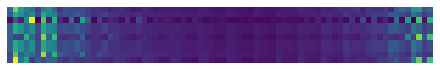

S2s


<Figure size 1440x432 with 0 Axes>

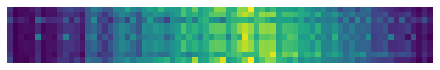

In [77]:
model.show_G_S(f"./figs/{m}/mfeat-fou")

Modified partition coefficient:  {0: 0.6247074786785543, 1: 0.03173425637491434, 2: 0.15056567370465979, 3: 0.02685505460227755, 4: 0.046362193153639986, 5: 0.06346592421945385, 6: 0.03843620740572351, 7: 0.1220733776825158, 8: 0.14189072105715728, 9: 0.03920434475554513}
Índice de Rand corrigido: 0.38865568691976343


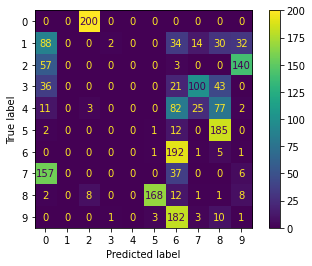

In [78]:
pertencify = pipeline.predict(X, is_preprocessing=True, argmax=False)
y_predict = pertencify.argmax(1)

mpcs = {i: Metrics.mpc(pertencify[y.values[:,0]==i]) for i in range(model.num_class)}

# model.init_u
print(f"Modified partition coefficient:  {mpcs}")# f,
print(f"Índice de Rand corrigido: {Metrics.ars(y.values[:,0], y_predict)}")# f,

cm = confusion_matrix(y.values[:,0], y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

#### datasets -> mfeat-zer

In [16]:
cleaner = Cleaner()
X, y = cleaner.read_dataset("datasets\mfeat-zer")
X_clean, y_clean = cleaner.transform(X, y)
X, y = Cleaner().transform(X, y)

model = Trainer(num_class = 10, 
                epochs = 100, 
                threshold = 1e-6, 
                model_creator=FuzzyCMeansGaussianS2, 
                m = m, 
                verbose = False, 
                repeat = 50, 
                filename=f"mfeat-zer/model.json",)

pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X_clean, y_clean)

metrics[m]["mfeat-zer"] = model.metrics

repeation: 1 funcão objetivo: 754.1397265450329
Modified partition coefficient: 0.023086847142524514,  adjusted rand score: 0.23698481871875876
repeation: 2 funcão objetivo: 741.5016351311858
Modified partition coefficient: 0.05257477966309876,  adjusted rand score: 0.2784697732197146
repeation: 3 funcão objetivo: 739.2222598859009
Modified partition coefficient: 0.045753783225457645,  adjusted rand score: 0.3073475167396266
repeation: 4 funcão objetivo: 738.9719012391694
Modified partition coefficient: 0.0463353537316048,  adjusted rand score: 0.3075416426400738
repeation: 5 funcão objetivo: 739.6815168883574
Modified partition coefficient: 0.04519812166189763,  adjusted rand score: 0.30126222481715925
repeation: 6 funcão objetivo: 739.6269715226533
Modified partition coefficient: 0.04538429424958257,  adjusted rand score: 0.3027287246775633
repeation: 7 funcão objetivo: 741.4218556916884
Modified partition coefficient: 0.05264573195014455,  adjusted rand score: 0.2764948487463571
rep

Gs


<Figure size 1440x432 with 0 Axes>

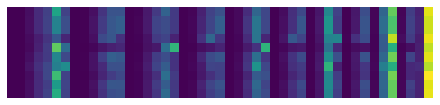

S2s


<Figure size 1440x432 with 0 Axes>

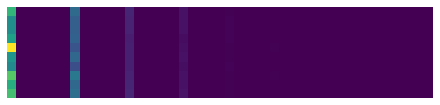

In [17]:
model.show_G_S(f"./figs/{m}/mfeat-zer")

Modified partition coefficient:  {0: 0.20482414140370497, 1: 0.10351432764787527, 2: 0.05215672758306844, 3: 0.011699780114431957, 4: 0.011790337867904843, 5: 0.014409250732995815, 6: 0.018402380653946504, 7: 0.006343301016093927, 8: 0.019443414376652313, 9: 0.019547264930402264}
Índice de Rand corrigido: 0.30810544131443723


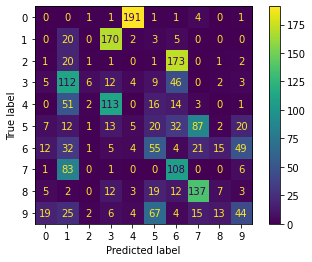

In [18]:
pertencify = pipeline.predict(X, is_preprocessing=True, argmax=False)
y_predict = pertencify.argmax(1)

mpcs = {i: Metrics.mpc(pertencify[y==i]) for i in range(model.num_class)}

# model.init_u
print(f"Modified partition coefficient:  {mpcs}")# f,
print(f"Índice de Rand corrigido: {Metrics.ars(y, y_predict)}")# f,

cm = confusion_matrix(y, y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

#### datasets -> iris

In [68]:
iris = datasets.load_iris()
X = pd.DataFrame(iris.data)
y = pd.DataFrame({len(X.columns.values):iris.target})
cleaner = Cleaner()

In [69]:
X_clean, y_clean = cleaner.transform(X, y)

model = Trainer(num_class = 3, 
                epochs = 100, 
                threshold = 1e-6, 
                model_creator=FuzzyCMeansGaussianS2, 
                m = m, 
                verbose = False, 
                repeat = 50, 
                filename=f"iris/model.json",)

pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X_clean, y_clean)

metrics[m] = {"iris": model.metrics}


repeation: 1 funcão objetivo: 0.3699555551337107
Modified partition coefficient: 0.8442132888936337,  adjusted rand score: 0.9035691663683182
repeation: 2 funcão objetivo: 0.36995545604974767
Modified partition coefficient: 0.8442128315528195,  adjusted rand score: 0.9035691663683182
repeation: 3 funcão objetivo: 0.36995593742345245
Modified partition coefficient: 0.8442151260073463,  adjusted rand score: 0.9035691663683182
repeation: 4 funcão objetivo: 0.3699556847186088
Modified partition coefficient: 0.844212253864933,  adjusted rand score: 0.9035691663683182
repeation: 5 funcão objetivo: 0.3699554602258903
Modified partition coefficient: 0.8442129359914474,  adjusted rand score: 0.9035691663683182
repeation: 6 funcão objetivo: 0.3699543013063209
Modified partition coefficient: 0.8442070393599654,  adjusted rand score: 0.9035691663683182
repeation: 7 funcão objetivo: 0.5234712014182967
Modified partition coefficient: 0.8919640708723391,  adjusted rand score: 0.443540461316264
repeat

In [71]:
new_model = Model()
new_model.load_model(f"model/{m}/iris/model.json")
y_predict = new_model.predict(X, True)#.shape, X.shape


Gs


<Figure size 1440x432 with 0 Axes>

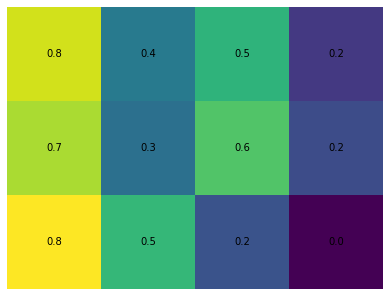

S2s


<Figure size 1440x432 with 0 Axes>

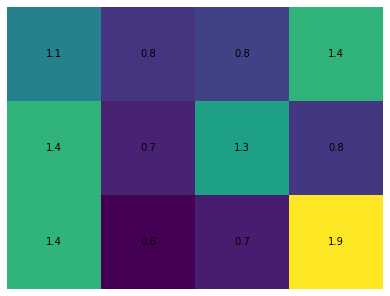

In [72]:
model.show_G_S(f"figs/{m}/iris")

Modified partition coefficient:  {0: 0.9878277219413591, 1: 0.7805127217493312, 2: 0.7671528594218375}
Índice de Rand corrigido: 0.9038742317748124


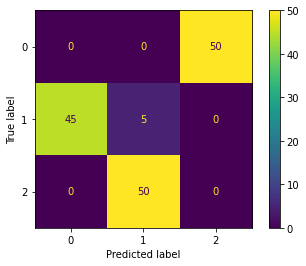

In [73]:
pertencify = pipeline.predict(X, is_preprocessing=True, argmax=False)
y_predict = pertencify.argmax(1)

mpcs = {i: Metrics.mpc(pertencify[y.values[:,0]==i]) for i in range(model.num_class)}

# model.init_u
print(f"Modified partition coefficient:  {mpcs}")# f,
print(f"Índice de Rand corrigido: {Metrics.ars(y.values[:,0], y_predict)}")# f,

cm = confusion_matrix(y.values[:,0], y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

# show experiments

In [93]:
# metrics = {}
metrics[1.1]["mfeat-fac"]["objetive_function"]

[12.695396592612276,
 12.8404760851869,
 12.679782558771912,
 12.63551420604752,
 12.714638791208772,
 12.695395261733871,
 12.691577813701443,
 12.978546176282334,
 12.840475114721507,
 12.888360517056407,
 12.695129654346207,
 12.635590148284711,
 12.874888344801196,
 12.864909575178617,
 12.844872966147632,
 12.840475684864934,
 12.752260104535024,
 12.624314873641861,
 12.624315012099544,
 12.864910703708672,
 12.65014171685571,
 12.708692282884446,
 12.744178115566758,
 12.874610493056142,
 12.695378006591309,
 12.8649074683744,
 12.635695185259989,
 12.880374327894087,
 12.87362539899419,
 12.87359309401085,
 12.97854838794099,
 12.840449400939981,
 12.695395968250898,
 12.62431493064446,
 12.624314786548169,
 12.635502736917134,
 12.69157831773381,
 12.624314888261837,
 12.650906176858047,
 12.635676396071721,
 12.833514916263425,
 12.87359273995779,
 12.63550287651512,
 12.714507181111358,
 12.635501568781008,
 12.624314668571156,
 12.888367545336138,
 12.636532647110839,
 12.8

In [19]:
dirs = os.listdir(f"./metrics/{m}/")

m_i = 1.1
for m_i in [1.1, 1.6]:
  metrics[m_i] = {file_name: {} for file_name in dirs}
  for file_name in dirs:
    # print(file_name)
    with open(f"./metrics/{m_i}/{file_name}/model.json", 'r') as openfile:
      metrics[m_i][file_name] = json.load(openfile)
metrics[m_i].keys()

dict_keys(['iris', 'mfeat-fac', 'mfeat-fou', 'mfeat-zer'])

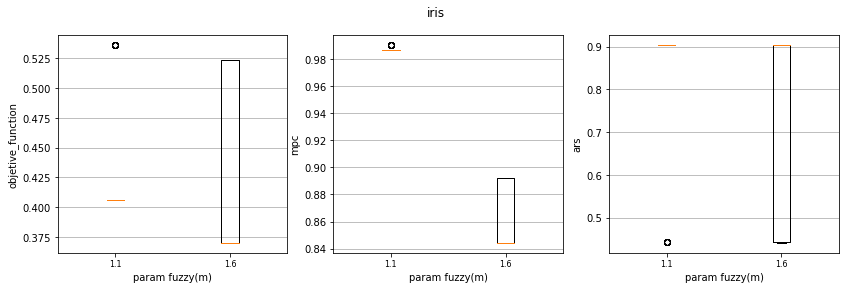

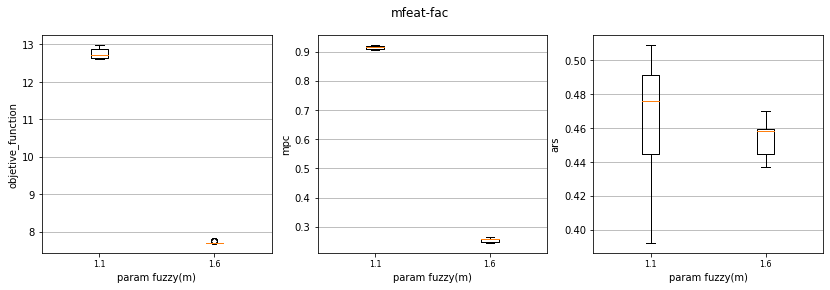

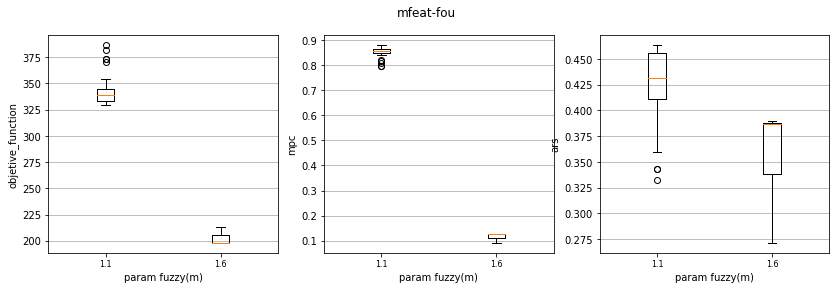

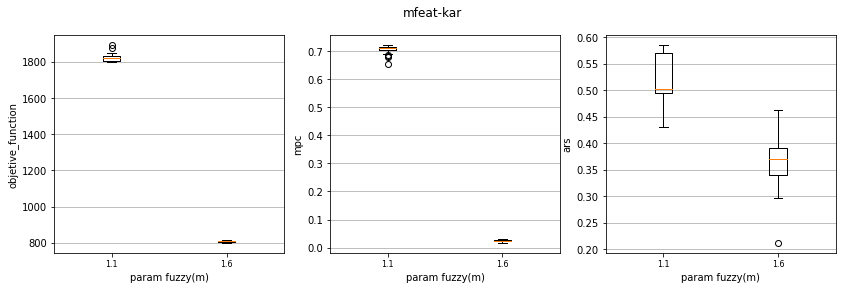

In [ ]:
def show_box(data_f, params, xlabel, title):
  fig, axs = plt.subplots(nrows=1, ncols=len(data_f), figsize=(14, 4))
  # name_y, d_f = data_f
  # plot box plot
  # plt.title(title, fontdict={})
  fig.suptitle(title)
  fig.subplots_adjust(hspace=1.4)
  for i, (ax, (name_y, d_f)) in enumerate(zip(axs, data_f.items())):
    ax.boxplot(d_f)
    # ax.set_title('funcão objetivo e m ')
    ax.yaxis.grid(True)
    # ax.set_xticks([y + 1 for y in range(len(data_f))],
    #               labels=params)
    # ax.set_xticks(params, labels=params)
    xtickNames = plt.setp(ax, xticklabels=params)
    plt.setp(xtickNames, fontsize=8)
    # ax.set_xlabel(params, minor=True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(name_y)

  plt.show()


# metrics.key()

# raise Exception
labels = [str(key) for key in metrics.keys()]
data = {}
for key in metrics.keys():
  for dataset_name in metrics[key].keys():
    if not data.get(dataset_name):
      data[dataset_name] = {}
      
    for metric in metrics[key][dataset_name].keys(): 
      if not data[dataset_name].get(metric):
        data[dataset_name][metric] = [metrics[key][dataset_name][metric]]
      else:
        data[dataset_name][metric].append(metrics[key][dataset_name][metric])
        
for dataset_name, d in data.items(): 
  show_box(d, labels, xlabel = "param fuzzy(m)", title=dataset_name)
